# 0. Import Required Libraries

In [1]:
%matplotlib inline

import mlflow
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import math
from lib.utils import *

# 1. Define Classifier Architecture

In [2]:
class Classifier(nn.Module):
    def __init__(self, channel, in_len):
        super(Classifier, self).__init__()
        
        self.fc1_size = channel * in_len ** 2
        self.fc2_size = self.fc1_size * 2
        self.fc3_size = self.fc2_size
        self.fc4_size = self.fc1_size
        
        self.fc1 = nn.Linear(self.fc1_size, self.fc2_size)
        self.fc2 = nn.Linear(self.fc2_size, self.fc3_size)
        self.fc3 = nn.Linear(self.fc3_size, self.fc4_size)
        self.fc4 = nn.Linear(self.fc4_size, 2)
        
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        # Flatten input
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        
        x = self.dropout(F.relu(self.fc2(x)))
        
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
    
    def train_network(self, trainloader, val_loader, epochs=20):
        pass
                    
    def test(self):
        pass

# 2. Start MlFlow Run

In [3]:
mlflow.set_tracking_uri("file:.\mlruns")
mlflow.start_run()

params = {}
artifacts = []
metrics = {}

# 3. Load Data

In [4]:
data, filenames = load_data(10, "./data/modis")

In [5]:
labels = [data[i][0] for i in range(len(data))]
train_data = [data[i][1:] for i in range(len(data))]

In [6]:
class LandsatDataLoader():
    def __init__(self, data, ground_truth, batch_size, shuffle=True):
        self.data = data
        self.labels = ground_truth
        self.batch_size = batch_size
        self.shuffle = shuffle
    def __len__(self):
        return self.len
    def __iter__(self):
        self.len = 0
        if self.shuffle:
            import random
            random.shuffle(self.data)
        
        for i, image in enumerate(self.data):
            chunked_data = chunk_image(merge_dims(image))
            chunked_labels = chunk_image(self.labels[i], label=True)
                        
            dataset = list(zip(chunked_data, chunked_labels))
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=self.shuffle)
            self.len += len(dataloader)
            
            for batch, ground_truth in dataloader:
                yield batch, ground_truth 

# 4. Chunk Images
Each image is broken up into bx9x3x3 tensors, where b is the batch size. 

In [83]:
%%time

print("{:30} shape: (batch, band, height, width)".format("filename"))

chunk_sum = 0

for i, image in enumerate(train_data):
    chunked_image = chunk_image(merge_dims(image))
    
    chunk_sum += chunked_image.shape[0]
        
    print("{:30} shape: {}".format(filenames[i], chunked_image.shape))
    
print("\nTotal {} x {} chunks: {}".format(chunked_image.shape[-1], chunked_image.shape[-1], chunk_sum))

filename                       shape: (batch, band, height, width)
arkansas_city.tif              shape: (556850, 9, 3, 3)
assiniboine.tif                shape: (2182830, 9, 3, 3)
bay_area.tif                   shape: (3165612, 9, 3, 3)
berkeley.tif                   shape: (431616, 9, 3, 3)
kashmore.tif                   shape: (3304125, 9, 3, 3)
kashmore_north.tif             shape: (328040, 9, 3, 3)
katrina.tif                    shape: (1263893, 9, 3, 3)
katrina_slidell.tif            shape: (249676, 9, 3, 3)
malawi.tif                     shape: (423504, 9, 3, 3)
mississippi_june.tif           shape: (824680, 9, 3, 3)
mississippi_may.tif            shape: (824680, 9, 3, 3)
parana.tif                     shape: (686907, 9, 3, 3)
sava.tif                       shape: (753087, 9, 3, 3)
sava_west.tif                  shape: (410116, 9, 3, 3)
unflooded_mississippi.tif      shape: (1662630, 9, 3, 3)
unflooded_new_orleans.tif      shape: (1403010, 9, 3, 3)

Total 3 x 3 chunks: 18471256
W

In [8]:
batch_size = 2048
params["batch_size"] = batch_size

In [9]:
trainloader = LandsatDataLoader(train_data[:12], labels[:12], batch_size=batch_size)
val_loader = LandsatDataLoader(train_data[12:15], labels[12:15], batch_size=batch_size)

# 5. Instantiate Model and Optimizer

In [10]:
model = Classifier(9, 3)

In [11]:
#model = parallelize(model)

In [12]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# 6. Use GPU, if available

In [13]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
model.to(device)

Classifier(
  (fc1): Linear(in_features=81, out_features=162, bias=True)
  (fc2): Linear(in_features=162, out_features=162, bias=True)
  (fc3): Linear(in_features=162, out_features=81, bias=True)
  (fc4): Linear(in_features=81, out_features=2, bias=True)
  (dropout): Dropout(p=0.3)
)

# 7. Train and Validate Model

In [14]:
%%time

epochs = 30
params["epochs"] = epochs

train_losses = []
val_losses = []
val_accuracies = []

min_val_loss = float("inf")


for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for batch, ground_truth in trainloader:
        # ============================================
        #            TRAINING
        # ============================================
        batch, ground_truth = batch.to(device), ground_truth.to(device)
        output = model.forward(batch.float())
        # Clear gradients in optimizer
        optimizer.zero_grad()
        # Calculate loss
        loss = criterion(output.squeeze(), ground_truth.long())
        train_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()
    else:
        with torch.no_grad():
            model.eval()
            val_loss = 0
            
            y_pred = np.array([])
            y_true = np.array([])
            
            for batch, ground_truth in val_loader:
                # ============================================
                #            VALIDATION
                # ============================================
                batch, ground_truth = batch.to(device), ground_truth.to(device)
                # forward pass
                log_probs = model.forward(batch.float())
                probs = torch.exp(log_probs)
                
                top_p, top_class = probs.topk(1, dim=1)
                y_pred = np.append(y_pred, cuda_to_numpy(top_class))
                y_true = np.append(y_true, cuda_to_numpy(ground_truth))
                
                # calculate loss
                loss = criterion(log_probs.squeeze(), ground_truth.long())
                val_loss += loss.item()

    # Print epoch summary
    t_loss_avg = train_loss / len(trainloader)
    v_loss_avg = val_loss / len(val_loader)
    accuracy = accuracy_score(y_true, y_pred)
    
    if v_loss_avg < min_val_loss:
        torch.save(model.state_dict(), "./artifacts/model.pth")
        artifacts.append("model.pth")
        
    mlflow.log_metric("train_loss", t_loss_avg)
    mlflow.log_metric("val_loss", v_loss_avg)
    mlflow.log_metric("validation_accuracy", accuracy)
    
    train_losses.append(t_loss_avg)
    val_losses.append(v_loss_avg)
    val_accuracies.append(accuracy)
    
    print('Epoch [{:5d}/{:5d}] | train loss: {:8.6f} | validation loss: {:8.6f} | validation accuracy: {:6.4f}%'.format(
                epoch+1, epochs, t_loss_avg, v_loss_avg, accuracy * 100))

Epoch [    1/   30] | train loss: 0.238680 | validation loss: 0.154067 | validation accuracy: 97.6694%
Epoch [    2/   30] | train loss: 0.179612 | validation loss: 0.178584 | validation accuracy: 97.4747%
Epoch [    3/   30] | train loss: 0.174550 | validation loss: 0.146578 | validation accuracy: 97.6518%
Epoch [    4/   30] | train loss: 0.170724 | validation loss: 0.169868 | validation accuracy: 97.4576%
Epoch [    5/   30] | train loss: 0.168265 | validation loss: 0.143538 | validation accuracy: 97.5963%
Epoch [    6/   30] | train loss: 0.166092 | validation loss: 0.137881 | validation accuracy: 97.5885%
Epoch [    7/   30] | train loss: 0.163846 | validation loss: 0.119091 | validation accuracy: 97.5685%
Epoch [    8/   30] | train loss: 0.161922 | validation loss: 0.146896 | validation accuracy: 97.5629%
Epoch [    9/   30] | train loss: 0.160449 | validation loss: 0.125387 | validation accuracy: 97.5187%
Epoch [   10/   30] | train loss: 0.159286 | validation loss: 0.129012 | 

# 8. Plot Learning Curve

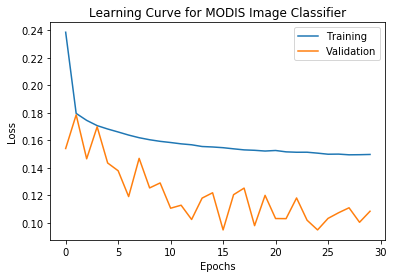

In [15]:
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve for MODIS Image Classifier")
plt.legend()

figure_name = "train_loss.png"
plt.savefig("./artifacts/" + figure_name)
artifacts.append(figure_name)

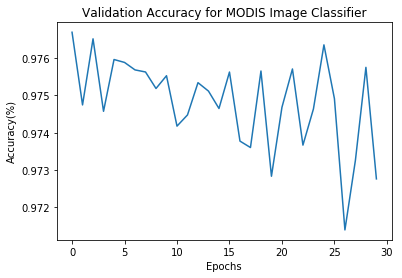

In [16]:
plt.plot(val_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.title("Validation Accuracy for MODIS Image Classifier")

figure_name = "val_accuracy.png"
plt.savefig("./artifacts/" + figure_name)
artifacts.append(figure_name)

# 8. Test Model

In [42]:
model.load_state_dict(torch.load("./artifacts/model.pth"))

In [69]:
test_i = 15
params["test_image"] = test_i

testimage = train_data[test_i]
test_labels = labels[test_i]

chunked_data = chunk_image(merge_dims(testimage))
chunked_labels = chunk_image(test_labels, label=True)
                        
testset = list(zip(chunked_data, chunked_labels))

testloader = DataLoader(testset, batch_size = batch_size, shuffle = False)

In [70]:
merged_image = merge_dims(train_data[test_i])
pred_shape = (merged_image.shape[1] - 2, merged_image.shape[2] - 2)
pred_shape

(1060, 778)

In [71]:
y_pred = np.array([])
y_true = np.array([])

model.eval()
for batch, ground_truth in testloader:
        batch, ground_truth = batch.to(device), ground_truth.to(device)
        # forward pass
        log_probs = model.forward(batch.float())
        probs = torch.exp(log_probs)
                
        top_p, top_class = probs.topk(1, dim=1)
        y_pred = np.append(y_pred, cuda_to_numpy(top_class))
        y_true = np.append(y_true, cuda_to_numpy(ground_truth))

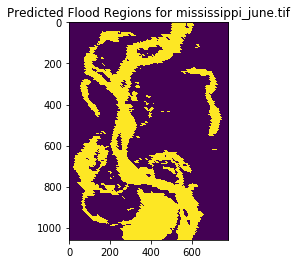

In [72]:
plt.title("Predicted Flood Regions for {}".format(filenames[test_i]))
plt.imshow(np.reshape(y_pred, pred_shape))

figure_name = "predicted_image.png"
plt.savefig("./artifacts/" + figure_name)

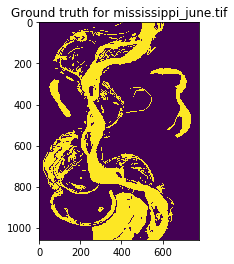

In [73]:
plt.title("Ground truth for {}".format(filenames[test_i]))
plt.imshow(np.reshape(y_true, pred_shape))

In [74]:
test_accuracy = accuracy_score(y_true, y_pred)
test_accuracy

0.8978330988989669

# 9. Wrap up MlFlow Run

In [ ]:
for name, val in params.items():
    mlflow.log_param(name, val)

for name, val in metrics.items():
    mlflow.log_metric(name, val)
    
artifact_path = "./artifacts/"
for name in artifacts:
    mlflow.log_artifact(artifact_path + name)

mlflow.end_run()